## Mobile Phone Price Classification

Author: Mike Kale

In this project I'll be classifying mobile phone prices based upon a series of features that are provided in a testing/training set.

This data is available from Kaggle.com:
https://www.kaggle.com/iabhishekofficial/mobile-price-classification

I'll be testing several classification models to determine which is the best, before running on the test set.

In [1]:
# Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize

In [2]:
# load data set
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")

In [3]:
test_data.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


In [4]:
train_data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

We can see from the sample data above that we most likely have a lot of old phones - especially if there is a lack of a touch screen interface. Just out of curiousity I wanted to do a tiny bit of analysis here.

In [6]:
train_data.groupby(['price_range','touch_screen']).size().reset_index(name='counts')

,price_range,touch_screen,counts
0,0,0,238
1,0,1,262
2,1,0,239
3,1,1,261
4,2,0,265
5,2,1,235
6,3,0,252
7,3,1,248


I think we can stop here, I would venture to guess that this data is probably randomly generated for use in projects only. Things are a little bit too evenly spaced, and I couldn't see having this many phones without a touchscreen being that expensive.

<AxesSubplot:xlabel='price_range', ylabel='count'>

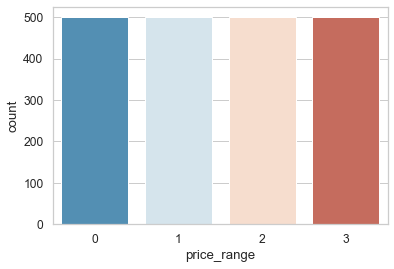

In [7]:
# counts of price_range
sns.set(font_scale=1.1)
sns.set_style('whitegrid')
sns.countplot(x='price_range',data=train_data,palette='RdBu_r')

We can see here that the split of price ranges is exact at 25% per price_range - this was unexpected, but also means that we won't need to worry about applying any special methods to even out the dataset

<AxesSubplot:>

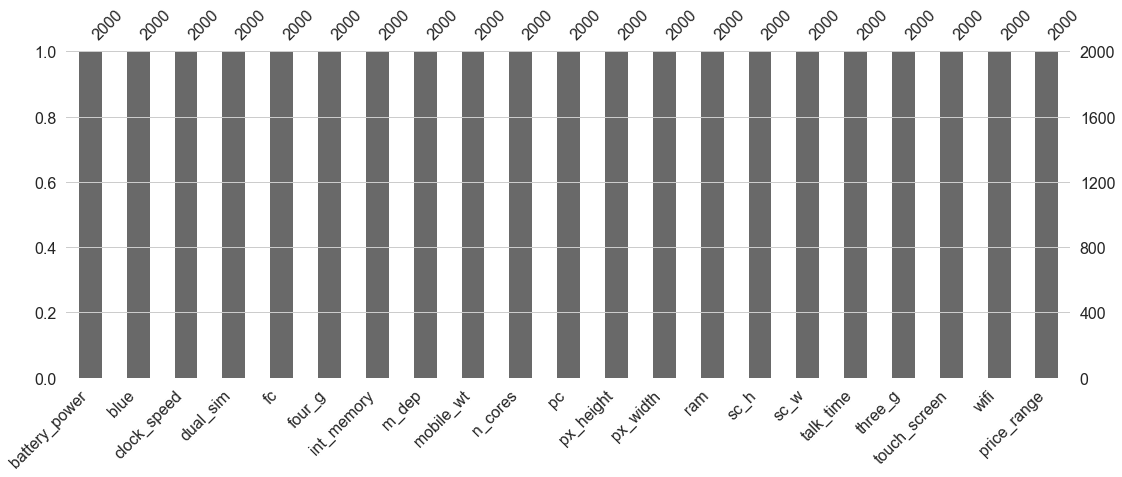

In [8]:
# Show any missing values
msno.bar(train_data, figsize=(18, 6))

The data is very "clean" in most respects, containing no missing values.

## Correlations

In [9]:
# Get correlations of each features in dataset
corrmat = train_data.corr()

# Print and sort correlations
correlations = train_data.corr()['price_range'].dropna().sort_values()
print(correlations)

touch_screen    -0.030411
mobile_wt       -0.030302
clock_speed     -0.006606
m_dep            0.000853
n_cores          0.004399
four_g           0.014772
dual_sim         0.017444
wifi             0.018785
blue             0.020573
talk_time        0.021859
fc               0.021998
sc_h             0.022986
three_g          0.023611
pc               0.033599
sc_w             0.038711
int_memory       0.044435
px_height        0.148858
px_width         0.165818
battery_power    0.200723
ram              0.917046
price_range      1.000000
Name: price_range, dtype: float64


Here we attempt to find relevant features above 0.05. The interesting thing here is that we see, potentially, that only a small subset of features are even relevant to pricing.

C:\Users\kaled\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

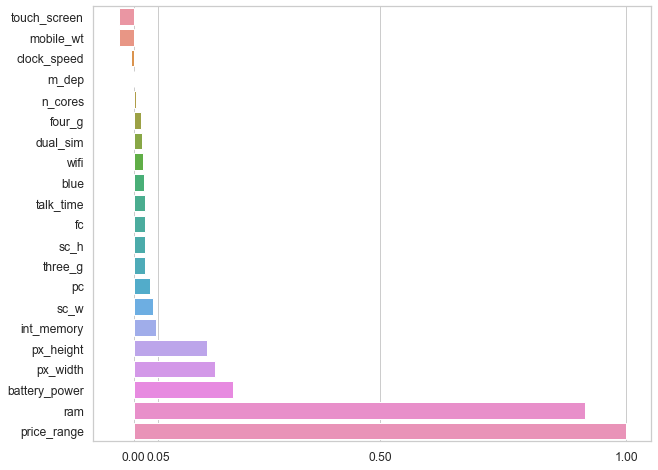

In [10]:
# Plot coorelations
plt.figure(figsize=(10, 8))
plt.xticks((0, 0.05, 0.5, 1))
sns.barplot(correlations.values, correlations.index)

Based on the test above, we can technically throw out all but <b>px_height, px_width, battery_power</b>, and <b>ram</b>

## Chi-Squared Test

In [11]:
#splitting the dataset for chi-square test
X = train_data.drop('price_range',axis=1)
y = train_data['price_range']
print(X.shape)
print(y.shape)

(2000, 20)
(2000,)


In [12]:
chi_scores = chi2(X,y)
chi_scores

(array([1.41298666e+04, 7.23232323e-01, 6.48365906e-01, 6.31010795e-01,
        1.01351665e+01, 1.52157239e+00, 8.98391244e+01, 7.45819631e-01,
        9.59728626e+01, 9.09755558e+00, 9.18605355e+00, 1.73635695e+04,
        9.81058675e+03, 9.31267519e+05, 9.61487832e+00, 1.64803191e+01,
        1.32364000e+01, 3.27642810e-01, 1.92842942e+00, 4.22090730e-01]),
 array([0.00000000e+00, 8.67726342e-01, 8.85276201e-01, 8.89297893e-01,
        1.74514323e-02, 6.77300459e-01, 2.37197834e-19, 8.62377379e-01,
        1.14084978e-20, 2.80215610e-02, 2.69167984e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.21401351e-02, 9.03765912e-04,
        4.15229208e-03, 9.54748475e-01, 5.87393502e-01, 9.35642196e-01]))

<AxesSubplot:>

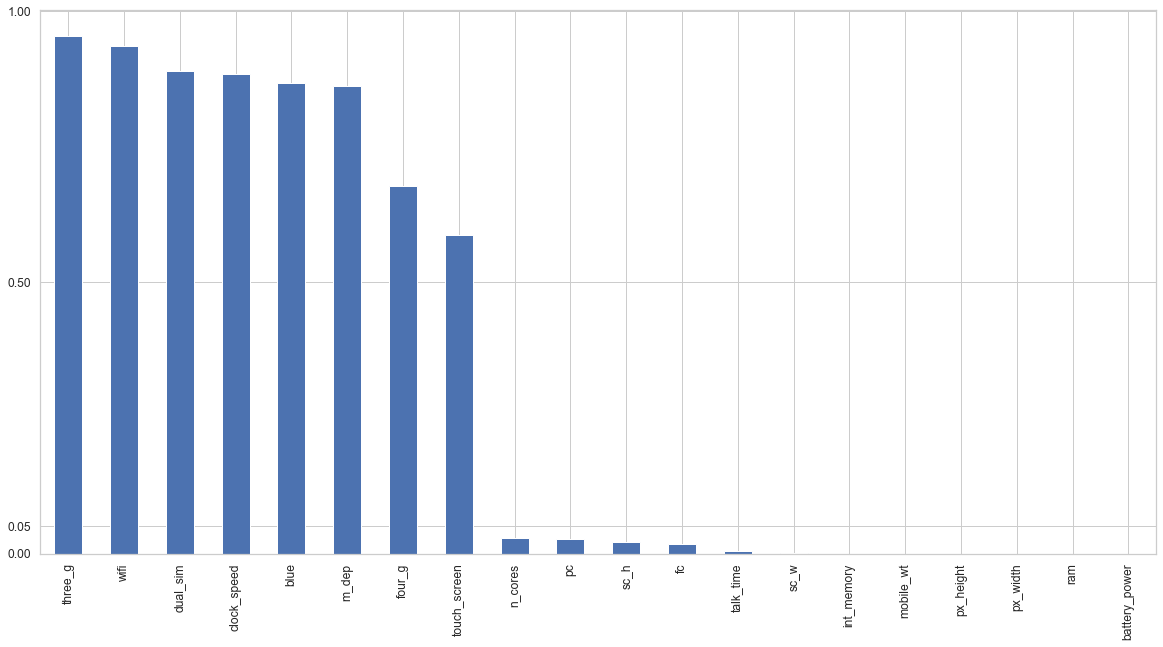

In [13]:
#plotting the p-values
plt.figure(figsize=(20,10))
plt.yticks((0, 0.05, 0.5, 1))
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

From this operation - we see eight features that we can remove due to insignificance (> 0.05)

Given the correlation and chi-squared test, we can eliminate all but px_width, px_height, battery_power, ram

## Train and Test Split

In [14]:
X = train_data[['px_width','px_height','battery_power','ram']]
y = train_data["price_range"]
X_train,X_test,y_train,y_test=train_test_split(X, y, train_size=0.8, stratify = y, random_state=100)

In [15]:
#shape of dataset
y_train.shape, y_test.shape

((1600,), (400,))

In [16]:
#actual dataset ratio of for each class in training set
y_train.value_counts()/len(y_train)

0    0.25
1    0.25
2    0.25
3    0.25
Name: price_range, dtype: float64

In [17]:
#standardization
Scaler_X = StandardScaler()
X_train = Scaler_X.fit_transform(X_train)
X_test = Scaler_X.transform(X_test)

### Model Comparison Algorithm

In [18]:
model = list()
precision = list()
recall = list()
F1score = list()

def test_eval(clf_model, X_test, y_test, algo=None):    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred,average='weighted'))
    recall.append(recall_score(y_test,y_pred,average='weighted'))
    F1score.append(f1_score(y_test,y_pred,average='weighted'))

### Model - Decision Tree

In [19]:
# Provide a dictionary of these values to test
param_grid = {'max_leaf_nodes': list(range(2, 100)), 
              'min_samples_split': [2, 3, 4]}

In [20]:
# Instantiate object
grid = GridSearchCV(DecisionTreeClassifier(),param_grid,verbose=1,cv=3,n_jobs=-1)

In [21]:
# Fit to find the best combo of params
grid.fit(X_train,y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [22]:
# Show the best params to use
rfc_params = grid.best_params_
rfc_params

{'max_leaf_nodes': 88, 'min_samples_split': 2}

In [23]:
# Print reports
test_eval(grid, X_test, y_test, 'Decision Tree')

Confusion Matrix
[[94  6  0  0]
 [ 8 85  7  0]
 [ 0 11 79 10]
 [ 0  0  7 93]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       100
           1       0.83      0.85      0.84       100
           2       0.85      0.79      0.82       100
           3       0.90      0.93      0.92       100

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400
 



### Model - Random Forest

In [24]:
# Provide a dictionary of these values to test
param_grid = {'n_estimators':[2,10,30,50,100],
           'max_depth':[i for i in range(5,16,2)],
           'min_samples_split':[2, 5, 10, 15, 20, 50, 100]}

In [25]:
# Instantiate object
grid = GridSearchCV(RandomForestClassifier(),param_grid,verbose=1,cv=3,n_jobs=-1)

In [26]:
# Fit to find the best combo of params
grid.fit(X_train,y_train)

Fitting 3 folds for each of 210 candidates, totalling 630 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9, 11, 13, 15],
                         'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
                         'n_estimators': [2, 10, 30, 50, 100]},
             verbose=1)

In [27]:
# Show the best params to use
rfc_params = grid.best_params_
rfc_params

{'max_depth': 13, 'min_samples_split': 5, 'n_estimators': 50}

In [28]:
# Print reports
test_eval(grid, X_test, y_test, 'Random Forest')

Confusion Matrix
[[97  3  0  0]
 [ 8 86  6  0]
 [ 0  8 84  8]
 [ 0  0  7 93]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       100
           1       0.89      0.86      0.87       100
           2       0.87      0.84      0.85       100
           3       0.92      0.93      0.93       100

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400
 



### Model - SVM

In [29]:
#Provide a dictionary of these values to test
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [30]:
#Instantiate object
grid = GridSearchCV(SVC(probability=True, decision_function_shape='ovr'),param_grid,verbose=1,cv=3,n_jobs=-1)

In [31]:
#Fit to find the best combo of params
grid.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             verbose=1)

In [32]:
#Show the best params to use
svc_params = grid.best_params_
svc_params

{'C': 1, 'kernel': 'linear'}

In [33]:
#Print reports
test_eval(grid, X_test, y_test, 'SVM')

Confusion Matrix
[[100   0   0   0]
 [  4  96   0   0]
 [  0   4  89   7]
 [  0   0   3  97]] 

Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       100
           1       0.96      0.96      0.96       100
           2       0.97      0.89      0.93       100
           3       0.93      0.97      0.95       100

    accuracy                           0.95       400
   macro avg       0.96      0.96      0.95       400
weighted avg       0.96      0.95      0.95       400
 



### Model - KNN

In [34]:
#Provide a dictionary of these values to test
param_grid = [{'n_neighbors':list(range(1,20)),
               'leaf_size':list(range(1,10)),
               'weights':['uniform','distance'],
               'metric':['euclidean','manhattan'],
               'p':[1,2]}]

In [35]:
#Instantiate object
grid = GridSearchCV(KNeighborsClassifier(),param_grid,verbose=1,cv=3,n_jobs=-1)

In [36]:
#Fit to find the best combo of params
grid.fit(X_train,y_train)

Fitting 3 folds for each of 1368 candidates, totalling 4104 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'metric': ['euclidean', 'manhattan'],
                          'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19],
                          'p': [1, 2], 'weights': ['uniform', 'distance']}],
             verbose=1)

In [37]:
#Show the best params to use
knn_params = grid.best_params_
knn_params

{'leaf_size': 1,
 'metric': 'manhattan',
 'n_neighbors': 15,
 'p': 1,
 'weights': 'distance'}

In [38]:
#Print reports
test_eval(grid, X_test, y_test, 'KNN')

Confusion Matrix
[[99  1  0  0]
 [ 7 89  4  0]
 [ 0 10 80 10]
 [ 0  0  9 91]] 

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       100
           1       0.89      0.89      0.89       100
           2       0.86      0.80      0.83       100
           3       0.90      0.91      0.91       100

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400
 



### Model - Logistic Regression

In [39]:
param_grid = [
    {'penalty' : ['l1', 'l2'],
    'C' : [0.001,0.01,0.1,1,10,100,1000],
    'solver' : ['liblinear']},
]

In [40]:
#Instantiate object
grid = GridSearchCV(LogisticRegression(),param_grid,verbose=1,cv=3,n_jobs=-1)

In [41]:
#Fit to find the best combo of params
grid.fit(X_train,y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}],
             verbose=1)

In [42]:
#Show the best params to use
lr_params = grid.best_params_
lr_params

{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [43]:
#Print reports
test_eval(grid, X_test, y_test, 'Logistic Regression')

Confusion Matrix
[[100   0   0   0]
 [  4  77  19   0]
 [  0  18  71  11]
 [  0   0   2  98]] 

Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       100
           1       0.81      0.77      0.79       100
           2       0.77      0.71      0.74       100
           3       0.90      0.98      0.94       100

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400
 



### Model Comparison

In [44]:
clf_eval_df = pd.DataFrame({'model':model,
                            'precision':precision,
                            'recall':recall,
                            'f1-score':F1score})

clf_eval_df

,model,precision,recall,f1-score
0,Decision Tree,0.876819,0.8775,0.876797
1,Random Forest,0.899295,0.9000,0.899401
2,SVM,0.955406,0.9550,0.954614
3,KNN,0.896292,0.8975,0.896413
4,Logistic Regression,0.860722,0.8650,0.861880


Here we can see that SVC is clearly the best choice for this dataset

## Re-run for entire training set before running on test set

In [45]:
# For later join
test_id = test_data['id']

# Standardization

# Scale features in original un-split training data
X = Scaler_X.fit_transform(X)

# Scale test data since we built model off of scaled data
test_data = Scaler_X.transform(test_data[['px_width','px_height','battery_power','ram']])

In [46]:
# Re-run fit on entire training set using best estimation of features
svc_full = SVC()
svc_full.set_params(**svc_params)

#Fit model
svc_full.fit(X,y)

SVC(C=1, kernel='linear')

In [47]:
# Run predictions on the test dataframe
full_predictions = svc_full.predict(test_data)

In [48]:
full_predictions

array([3, 3, 3, 3, 1, 3, 3, 1, 3, 0, 3, 3, 0, 0, 2, 0, 2, 1, 3, 2, 1, 3,
       1, 1, 3, 0, 2, 0, 3, 0, 2, 0, 3, 0, 1, 1, 3, 1, 2, 1, 1, 2, 0, 0,
       0, 1, 0, 3, 1, 2, 1, 0, 3, 0, 3, 1, 3, 1, 1, 3, 3, 3, 0, 1, 1, 1,
       2, 3, 1, 2, 1, 2, 2, 3, 3, 0, 2, 0, 2, 3, 0, 3, 3, 0, 3, 0, 3, 1,
       3, 0, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0, 3, 0, 2, 0, 1, 2, 3,
       3, 3, 1, 3, 3, 3, 3, 2, 3, 0, 0, 3, 2, 1, 2, 0, 3, 2, 3, 1, 0, 2,
       2, 1, 3, 1, 1, 0, 3, 2, 1, 2, 1, 2, 2, 3, 3, 3, 2, 3, 2, 3, 1, 0,
       3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 1, 0, 3, 0, 0, 0, 2, 1, 0, 1,
       0, 0, 1, 2, 1, 0, 0, 1, 1, 2, 2, 1, 0, 0, 0, 1, 0, 3, 1, 0, 2, 2,
       3, 3, 1, 1, 3, 2, 3, 2, 2, 1, 1, 0, 1, 2, 0, 2, 3, 3, 0, 2, 0, 3,
       2, 3, 3, 1, 0, 1, 0, 3, 0, 1, 0, 2, 2, 1, 2, 1, 3, 0, 3, 1, 2, 0,
       0, 2, 1, 3, 3, 3, 1, 1, 3, 0, 0, 2, 3, 3, 1, 3, 1, 1, 3, 2, 1, 2,
       3, 3, 3, 1, 0, 0, 2, 3, 1, 1, 3, 2, 0, 3, 0, 0, 2, 1, 0, 3, 2, 3,
       3, 2, 1, 3, 3, 2, 3, 1, 2, 1, 2, 0, 2, 3, 1,

In [49]:
#Merge into final dataframe
pred_df = pd.DataFrame(full_predictions)

#Drop indexes (can cause NaN when using Concat if you don't do this beforehand)
pred_df.reset_index(drop=True, inplace=True)
test_id.reset_index(drop=True, inplace=True)

submission = pd.concat([test_id.iloc[0:],pred_df], axis=1)
submission.columns=['id','price_range']
#submission.to_csv('submission.csv', index = False)

<AxesSubplot:xlabel='price_range', ylabel='count'>

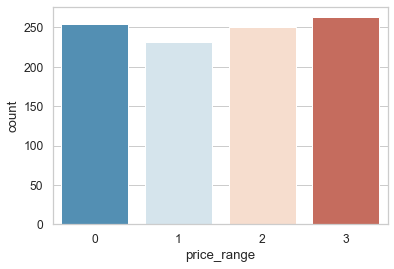

In [50]:
sns.countplot(x='price_range',data=submission,palette='RdBu_r')

In [51]:
pred_df.value_counts()

3    263
0    255
2    250
1    232
dtype: int64

In [52]:
submission.head()

,id,price_range
0,1,3
1,2,3
2,3,3
3,4,3
4,5,1


### Try out a manual prediction

Remember - the features we are left with are:
1. px_width
2. px_height
3. battery_power
4. ram

I'm going to pick out a random row from our test dataset that should represent a price_range of 3, with the following values for the features above:
1. 1698
2. 1771
3. 946
4. 3720

In [53]:
sample_test = Scaler_X.transform(np.array([1698,1771,946,3720]).reshape(1, -1))
sample_test

array([[ 1.03331035,  2.53767975, -0.66586148,  1.47150267]])

In [54]:
svc_full.predict(sample_test)

array([3], dtype=int64)

Success! - out model correctly identified this device as a price_range = 3